1. Read the column description and ensure you understand each attribute well
2. Study the data distribution in each attribute, share your findings. (5 points)
3. Get the target column distribution. Your comments
4. Split the data into training and test set in the ratio of 70:30 respectively
5. Use different classification models (Logistic, K-NN and Naïve Bayes) to predict the likelihood of a liability customer buying personal loans (15 points)
6. Print the confusion matrix for all the above models (5 points)
7. Give your reasoning on which is the best model in this case and why it performs better? (5 points)



In [978]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
from scipy.stats import zscore
from sklearn.neighbors import KNeighborsClassifier
import LocalitySensitiveHashing
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn import metrics
from scipy import stats
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import model_selection
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import mlxtend
import timeit

In [979]:
loan_df = pd.read_csv('Bank_Personal_Loan_Modelling-1.csv')

# 1. Read the column description and ensure you understand each attribute well

In [980]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
ID                    5000 non-null int64
Age                   5000 non-null int64
Experience            5000 non-null int64
Income                5000 non-null int64
ZIP Code              5000 non-null int64
Family                5000 non-null int64
CCAvg                 5000 non-null float64
Education             5000 non-null int64
Mortgage              5000 non-null int64
Personal Loan         5000 non-null int64
Securities Account    5000 non-null int64
CD Account            5000 non-null int64
Online                5000 non-null int64
CreditCard            5000 non-null int64
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


# 2. Study the data distribution in each attribute, share your findings. (5 points)

In [981]:
loan_df.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


Here on analysing the attributes, we can see that there is negetive value in 'Experience column' we need to identify such cases and impute those with mean or 0 years of experience 

In [982]:
 loan_df.loc[loan_df['Experience']<0, 'Experience'] = np.NaN

In [983]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 700)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#replacing negetive values with 0 because the minimum value is -3, so we can round it off to 0, cause the data is erroneous
loan_df = loan_df.replace(np.NaN, 0)
loan_df

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1.0,49,91107,4,1.60,1,0,0,1,0,0,0
1,2,45,19.0,34,90089,3,1.50,1,0,0,1,0,0,0
2,3,39,15.0,11,94720,1,1.00,1,0,0,0,0,0,0
3,4,35,9.0,100,94112,1,2.70,2,0,0,0,0,0,0
4,5,35,8.0,45,91330,4,1.00,2,0,0,0,0,0,1
5,6,37,13.0,29,92121,4,0.40,2,155,0,0,0,1,0
6,7,53,27.0,72,91711,2,1.50,2,0,0,0,0,1,0
7,8,50,24.0,22,93943,1,0.30,3,0,0,0,0,0,1
8,9,35,10.0,81,90089,3,0.60,2,104,0,0,0,1,0
9,10,34,9.0,180,93023,1,8.90,3,0,1,0,0,0,0


we can remove ID column as it's not going to matter in the analysis

In [984]:
loan_df.drop('ID',axis=1, inplace = True)

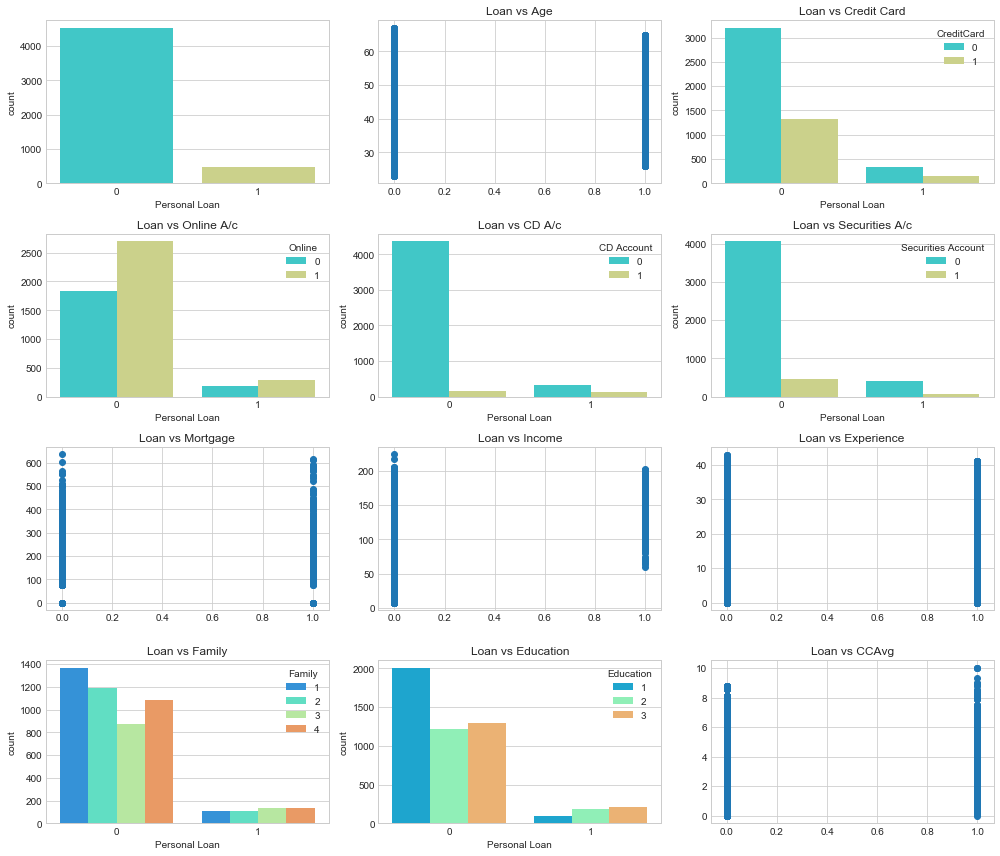

In [985]:
fig = plt.figure(figsize=(14,12))
sns.set_style('whitegrid')
plt.subplot2grid((4,3),(0,0))
sns.countplot(x='Personal Loan',data=loan_df,palette='rainbow')

plt.subplot2grid((4,3),(0,1))
plt.title("Loan vs Age")
plt.scatter(loan_df['Personal Loan'],loan_df.Age, alpha=0.5) # Loan vs Age

plt.subplot2grid((4,3),(0,2))
plt.title("Loan vs Credit Card")
sns.countplot(x='Personal Loan',hue='CreditCard',data=loan_df,palette='rainbow')

plt.subplot2grid((4,3),(1,0))
plt.title("Loan vs Online A/c")
sns.countplot(x='Personal Loan',hue='Online',data=loan_df,palette='rainbow')

plt.subplot2grid((4,3),(1,1))
plt.title("Loan vs CD A/c")
sns.countplot(x='Personal Loan',hue='CD Account',data=loan_df,palette='rainbow')

plt.subplot2grid((4,3),(1,2))
plt.title("Loan vs Securities A/c")
sns.countplot(x='Personal Loan',hue='Securities Account',data=loan_df,palette='rainbow')


plt.subplot2grid((4,3),(2,0))
plt.title("Loan vs Mortgage")
plt.scatter(loan_df['Personal Loan'],loan_df.Mortgage) # Loan vs Mortgage


plt.subplot2grid((4,3),(2,1))
plt.title("Loan vs Income")
plt.scatter(loan_df['Personal Loan'],loan_df.Income) # Loan vs Income

plt.subplot2grid((4,3),(2,2))
plt.title("Loan vs Experience")
plt.scatter(loan_df['Personal Loan'],loan_df.Experience) # Loan vs Experience

plt.subplot2grid((4,3),(3,0))
plt.title("Loan vs Family")
sns.countplot(x ='Personal Loan', hue ='Family', data = loan_df, palette ='rainbow')  # Loan vs Family

plt.subplot2grid((4,3),(3,1))
plt.title("Loan vs Education")
sns.countplot(x ='Personal Loan', hue ='Education', data = loan_df, palette ='rainbow') # Loan vs Education

plt.subplot2grid((4,3),(3,2))
plt.title("Loan vs CCAvg")
plt.scatter(loan_df['Personal Loan'],loan_df.CCAvg) # Loan vs CCAvg

plt.tight_layout()

In [986]:
#observations from the countplot and scatter plots
#1) The loan data has imbalance
#2) Majority Loan takers are having online account
#3) Loan takers fall in the middle to high income range
#4) Majority of the non-loan takers were from class 1 in Education

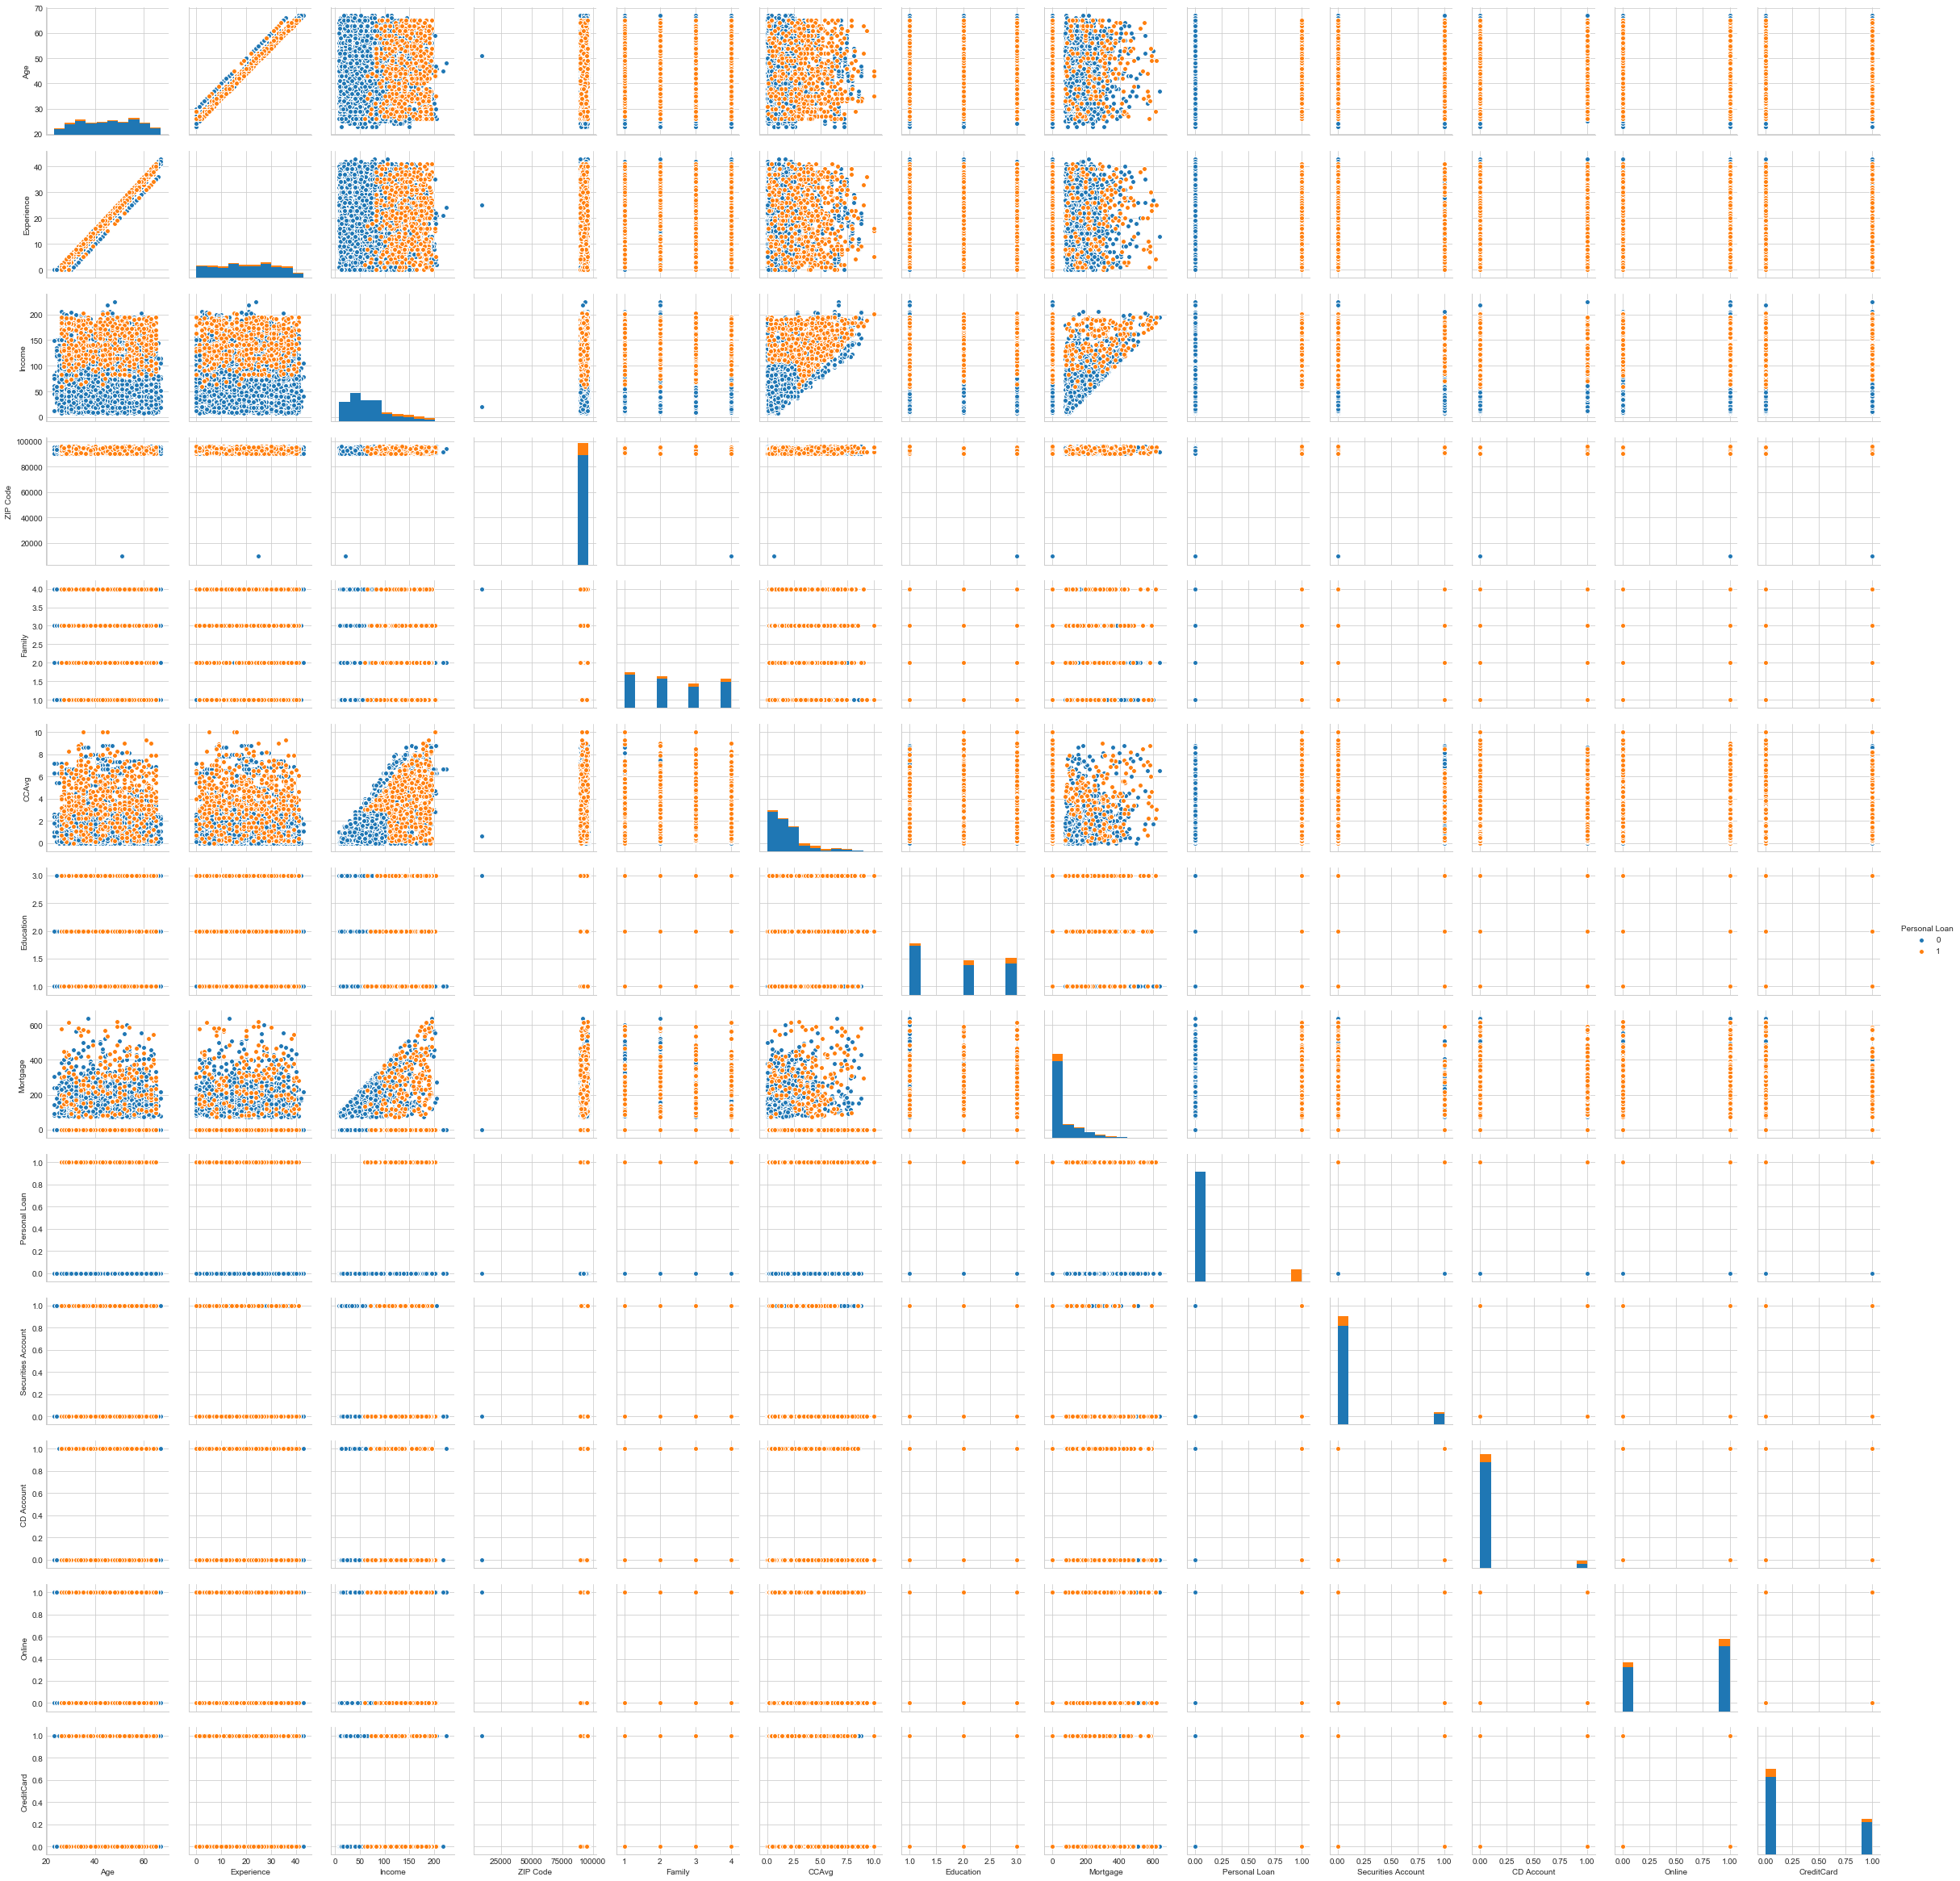

In [987]:
sns.pairplot(loan_df, hue='Personal Loan')

In [988]:

#observations from pairplot

#a) Zip code is not giving any good interpretation of the personal loan
#b) The pairplots show a mixed data where the personal loan classes overlap
#c) The plots are not very correlated as well, cause most of the plots show random distibution of points rather than a positive or negative slope.


In [989]:
loan_df.drop('ZIP Code', axis=1,inplace = True)

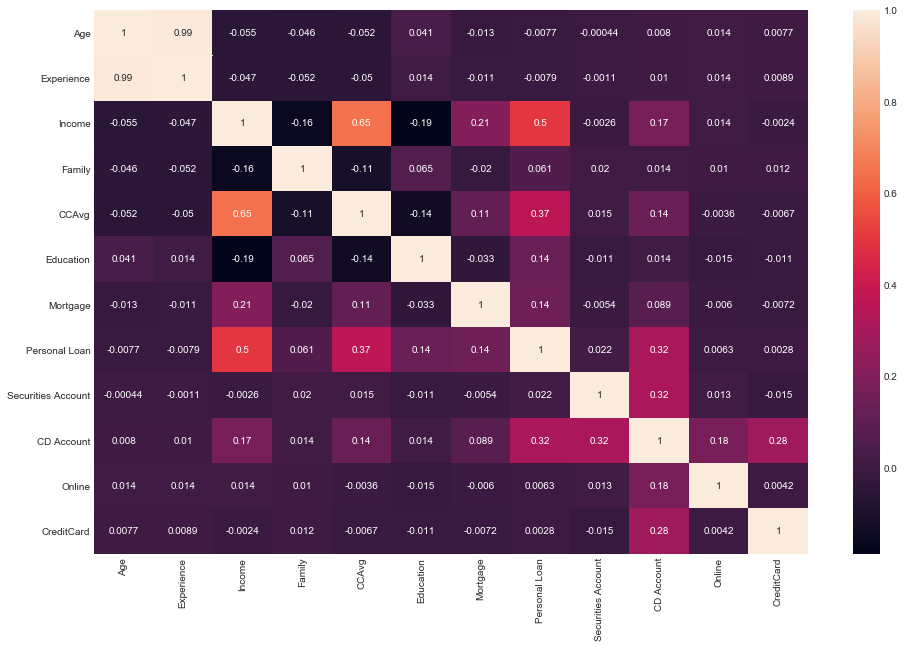

In [990]:
plt.figure(figsize=(16, 10))
sns.heatmap(loan_df.corr(), annot=True)

In [991]:
#observations based on collinearity
#1) Age and experience are highly correlated
#2)Income is one of the major factors that influences getting a loan.


# 3. Get the target column distribution. Your comments

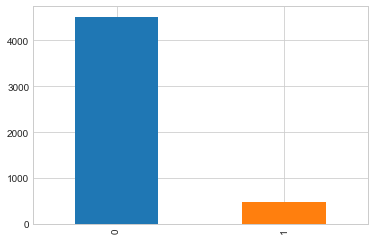

In [992]:
loan_df['Personal Loan'].value_counts().plot(kind='bar')
#plt.hist(x = loan_df['Personal Loan'])

# 4. Split the data into training and test set in the ratio of 70:30 respectively

In [993]:
# Feature Selection

from mlxtend.feature_selection import SequentialFeatureSelector as sfs

X = loan_df[['Age','Experience','Income','Family','CCAvg','Education','Securities Account','Mortgage','CD Account','Online','CreditCard']]
Y = loan_df['Personal Loan']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=1)

print('Training dataset shape:', x_train.shape, y_train.shape)
print('Testing dataset shape:', x_test.shape, y_test.shape)

logr = LogisticRegressionCV()
# Build step forward feature selection
sfs1 = sfs(logr, k_features=6, forward=True, scoring='accuracy', cv=5)
sfs1 = sfs1.fit(x_train, y_train)
results = sfs1.get_metric_dict()
pd.DataFrame(results).T

Training dataset shape: (3500, 11) (3500,)
Testing dataset shape: (1500, 11) (1500,)


,avg_score,ci_bound,cv_scores,feature_idx,feature_names,std_dev,std_err
1,0.909712,0.00777186,"[0.920114122681883, 0.9042857142857142, 0.9071...","(2,)","(Income,)",0.00604677,0.00302338
2,0.942857,0.00615062,"[0.9472182596291013, 0.9357142857142857, 0.947...","(2, 5)","(Income, Education)",0.00478539,0.0023927
3,0.945427,0.0055215,"[0.9500713266761769, 0.9385714285714286, 0.95,...","(2, 5, 8)","(Income, Education, CD Account)",0.00429591,0.00214796
4,0.948571,0.00309419,"[0.9514978601997147, 0.9442857142857143, 0.948...","(2, 5, 8, 10)","(Income, Education, CD Account, CreditCard)",0.00240739,0.00120369
5,0.952001,0.00563258,"[0.9557774607703281, 0.9485714285714286, 0.947...","(2, 3, 5, 8, 10)","(Income, Family, Education, CD Account, Credit...",0.00438234,0.00219117
6,0.95257,0.00218441,"[0.9557774607703281, 0.9528571428571428, 0.951...","(2, 3, 5, 8, 9, 10)","(Income, Family, Education, CD Account, Online...",0.00169955,0.000849773


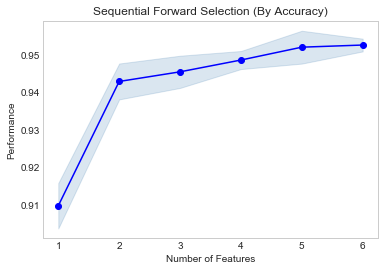

In [994]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs1.get_metric_dict())

plt.title('Sequential Forward Selection (By Accuracy)')
plt.grid()
plt.show()

In [995]:
# Features that are most important are as follows :

# Income, Family, Education, CD Account, CreditCard

In [996]:
# Create a separate dataframe consisting only of the features i.e independent attributes

X = loan_df[['Income','Family','Education','CD Account','CreditCard']]
Y = loan_df['Personal Loan']


In [997]:
#X_1 is the entire training plus validation set, there is no separate validation set as we are doing 10 fold cross validation.
#Using stratify to split the data such that the same ratio of the class 1 and 0 in personal loan is present in train and validation set.
X_1, X_test, Y_1, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 5, stratify = loan_df['Personal Loan'].values )

# 5. Use different classification models (Logistic, K-NN and Naïve Bayes) to predict the likelihood of a liability customer buying personal loans (15 points)

# 6) Print the confusion matrix for all the above models (5 points)

# KNN

In [998]:
X_1_z = X_1.apply(zscore)


In [999]:
X_test_z = X_test.apply(zscore)


The optimal number of neighbors is 5.
the misclassification error for each k value is :  [0.027 0.026 0.024 0.025 0.025 0.026 0.03  0.029 0.031 0.031]


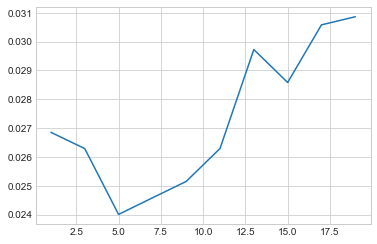

In [1000]:
#specifically for KNN we can do k-fold cross validation
# creating odd list of K for KNN
myList = list(range(0,20))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, weights = 'uniform', metric = 'euclidean')
    scores = cross_val_score(knn, X_1_z, Y_1, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())


# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [1001]:
#loan_feature_df_z = loan_feature_df.zscore

In [1002]:
NNH = KNeighborsClassifier(n_neighbors= 5 , weights = 'distance', metric='euclidean')
%timeit NNH.fit(X_1_z,Y_1)
test_prediction = NNH.predict(X_test_z)
test_prediction

6.35 ms ± 201 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


array([0, 0, 0, ..., 0, 0, 0])

In [1003]:
 #get the accuracy score which is how many test cases were correctly predicted as a ratio of total number of test cases

print(metrics.classification_report(Y_test, test_prediction))

             precision    recall  f1-score   support

          0       0.98      0.99      0.99      1356
          1       0.92      0.85      0.88       144

avg / total       0.98      0.98      0.98      1500



In [1004]:
#confusion matrix
print(metrics.confusion_matrix(Y_test, test_prediction))

[[1345   11]
 [  22  122]]


# Naive Bayes

# Probability prediction on training set

In [1005]:
#adding only numerical variables for Gaussian NB
X_1_gnb = X_1.loc[:,['Income']]

In [1006]:
clf = GaussianNB()

In [1007]:
clf.fit(X_1_gnb, Y_1)

GaussianNB(priors=None)

In [1008]:
predict_numeric = clf.predict_proba(X_1_gnb)
predict_numeric

array([[9.89161794e-01, 1.08382063e-02],
       [9.95870312e-01, 4.12968830e-03],
       [7.92833844e-01, 2.07166156e-01],
       ...,
       [2.77473021e-01, 7.22526979e-01],
       [9.99698164e-01, 3.01835535e-04],
       [1.52690526e-01, 8.47309474e-01]])

In [1009]:
#taking all categorical variables as multinomial NB
X_1_mnb = X_1.loc[:,['Family','Education','CD Account','CreditCard']]

In [1010]:
clf_mnb = MultinomialNB()
%timeit clf_mnb.fit(X_1_mnb, Y_1)


1 ms ± 55.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [1011]:
#predict categorical gives the probability of categorical features with respect to class 0 and class 1 of personal loan.
predict_categorical = clf_mnb.predict_proba(X_1_mnb)
predict_categorical

array([[0.92157113, 0.07842887],
       [0.92692562, 0.07307438],
       [0.91610975, 0.08389025],
       ...,
       [0.91610975, 0.08389025],
       [0.92434749, 0.07565251],
       [0.9242339 , 0.0757661 ]])

In [1012]:
#since naive bayes involves multiplying the likelihood probabilities, I have multiplied the probabilities for the two sets of features categorical and numerical
all_features_proba = predict_numeric * predict_categorical

In [1013]:
all_features_proba

array([[9.11582955e-01, 8.50028244e-04],
       [9.23097704e-01, 3.01774422e-04],
       [7.26322812e-01, 1.73792215e-02],
       ...,
       [2.54195739e-01, 6.06129719e-02],
       [9.24068485e-01, 2.28346171e-05],
       [1.41121760e-01, 6.41973353e-02]])

In [1014]:
#argmax takes the index of the higher probability value in each list inside 2-D array
X_train_predict = []
for i in range(len(X_1.index)):
    
    X_train_predict.append(np.argmax(all_features_proba[i]))


In [1015]:
expected = Y_1
predicted = X_train_predict

print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

             precision    recall  f1-score   support

          0       0.91      1.00      0.95      3164
          1       0.87      0.10      0.18       336

avg / total       0.91      0.91      0.88      3500

[[3159    5]
 [ 303   33]]


# Probability prediction on test set

In [1016]:
X_test_gnb = X_test.loc[:,['Income']]
predict_test_numeric = clf.predict_proba(X_test_gnb)

In [1017]:
X_test_mnb = X_test.loc[:,['Family','Education','CD Account','CreditCard']]
predict_test_categorical = clf_mnb.predict_proba(X_test_mnb)

In [1018]:
test_all_features_proba = predict_test_numeric * predict_test_categorical

In [1019]:
X_test_predict = []
for i in range(len(X_test.index)):
    X_test_predict.append(np.argmax(test_all_features_proba[i]))

In [1020]:
expected = Y_test
predicted = X_test_predict


In [1021]:
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

             precision    recall  f1-score   support

          0       0.92      1.00      0.96      1356
          1       0.96      0.15      0.26       144

avg / total       0.92      0.92      0.89      1500

[[1355    1]
 [ 122   22]]


# Logistic Regression

In [1022]:
#Logistic regression takes care of outliers by usage of sigmoid function which doesn't let the points having a larger distance from the 'w' plane to go to a value higher than a given threshold.

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]



#Using GridSearchCV
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_1_z, Y_1)

print(model.best_estimator_)
print(model.score(X_1_z, Y_1))

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.6974358974358973


In [1023]:
%timeit model.score(X_test_z, Y_test)

948 µs ± 57 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [1024]:
#C = 100 implies lambda = 0.01, so the hyper parameter for which the score is the highest is 0.01.
predicted  = model.predict(X_test_z)
expected = Y_test

In [1025]:
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

             precision    recall  f1-score   support

          0       0.96      0.99      0.97      1356
          1       0.82      0.65      0.73       144

avg / total       0.95      0.95      0.95      1500

[[1336   20]
 [  50   94]]


# 7) Give your reasoning on which is the best model in this case and why it performs better? (5 points)

**The best model based on accuracy is KNN
But to evaluate the algorithm based on time complexity :**

**The time taken by KNN goes in milliseconds whereas for naive bayes and logistic regression is way lesser.
Considering time and space complexity the favorable algrorithm is Logistic regression whereas considering accuracy KNN is better**
